In [85]:
"""
Script written by Andrew Rohne. This calibrates the work from home model for MWCOG

Needs: 
  1: Visualizer Survey folder - reads one of the CSVs
  2: ActivitySim tours output

How To Use:
  1: Set the project_dir (cell 2) to the base of your project - this should include the visualizer summary inputs and the model data
  2: Set the output folder (where some CSV files are saved)
  2: Fix the census_auto_ownership_file (text should be relative to project_dir)
  3: Fix the hh file (again, should be relative to project_dir)
  4: You'll probably need to update some fields
  

"""

import sys
import pandas as pd
import os
import numpy as np
import time
import datetime
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from simpledbf import Dbf5

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

DAMPING_FACTOR = 0.75

MODEL_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output"
MODEL_INPUT = r"E:\Met_Council\metc-asim-model\Input\socioeconomic"

excel_file = "WFH_Report.xlsx"

vis_survey_summaries = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
asim_config_folder = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'

PERTYPEMAP = {1: 'FT', 2: 'PT', 3: 'U', 4: 'NW', 5: 'R', 6: 'SD', 7: 'SPD', 8: 'PS'}

asim_run_cmd = "python E:\Met_Council\metc-asim-model\source\activitysim\simulation.py -c E:\Met_Council\metc-asim-model\estimation\output\work_loc_estimation\destination_choice\work_location_choice\ActivitySim_Testing\configs -c E:\Met_Council\metc-asim-model\source\activitysim\configs -d E:\Met_Council\metc-asim-model\Input\socioeconomic -d E:\Met_Council\metc-asim-model\Base_2018\OMX -o output\work_loc_estimation\destination_choice\work_location_choice\ActivitySim_Testing\outputs"

def launch_activitysim(activitysim_run_command):
    start_time = time.time()
    print("ActivitySim run started at: ", datetime.datetime.now())
    print(activitysim_run_command)
    ret_value = os.system(activitysim_run_command)
    end_time = time.time()
    print("ActivitySim ended at", datetime.datetime.now())
    run_time = round(time.time() - start_time, 2)
    print("Run Time: ", run_time, "secs = ", run_time/60, " mins")
    assert ret_value == 0, "ActivitySim run not completed! See ActivitySim log file for details."
    return

# Initialize Excel file if it doesn't exist
if not os.path.exists(excel_file):
    pd.DataFrame().to_excel(excel_file)


SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base2018'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'
ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'

DAMPING = 0.75

In [86]:
# Read all files...
modWFH_in = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_persons.csv"))
#lu_in = lu.copy() #pd.read_csv(os.path.join(MODEL_INPUT, "landuse", "land_use.csv"))
obsWFH = pd.read_csv(os.path.join(CENSUS_SUMMARY_PATH, "census_acs_2018_wfh.csv")).rename(columns = {'wfh': 'ObsWFH', 'tot_wrk': 'ObsWorkers', 'pct_wft': 'ObsWFHPct'})

asim_config = pd.read_csv(os.path.join(ASIM_CONFIGS_PATH, "work_from_home_coefficients.csv"))
households = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_households.csv"))
modWFHJ = modWFH_in[modWFH_in['household_id'].isin(households[households['TYPE'] == 1]['household_id'])].rename(columns = {'home_county': 'COUNTY'})

syn_hh = pd.read_csv(os.path.join(MODEL_INPUT, "synthetic_households.csv"))

SAMPLE_RATE = households.shape[0] / syn_hh.shape[0]

In [87]:
modWFH = modWFHJ[modWFHJ['is_worker']].groupby(['COUNTY', 'work_from_home']).agg(ModWorkers = ('person_id', 'count')).reset_index().pivot(index = 'COUNTY', columns = 'work_from_home', values = 'ModWorkers').reset_index().rename(columns = {True: 'ModWFH', False: 'ModWOOH'})

modWFH['ModWorkers'] = (modWFH['ModWOOH'].fillna(0) + modWFH['ModWFH'].fillna(0)) / SAMPLE_RATE
modWFH['ModWFH'] = modWFH['ModWFH'] / SAMPLE_RATE
wfhCompare = obsWFH.merge(modWFH, left_on = 'county', right_on = 'COUNTY')
wfhCompare['ModWFHPct'] = wfhCompare['ModWFH'].fillna(0) / wfhCompare['ModWorkers']
wfhCompare = wfhCompare[['COUNTY', 'ObsWorkers', 'ModWorkers', 'ObsWFH', 'ObsWFHPct', 'ModWFH', 'ModWFHPct']]
wfhCompare = wfhCompare.append({'COUNTY': 'Total', 'ObsWorkers': wfhCompare.ObsWorkers.sum(), 'ModWorkers': wfhCompare.ModWorkers.sum(), 'ObsWFH': wfhCompare.ObsWFH.sum(), 'ObsWFHPct': wfhCompare.ObsWFH.sum() / wfhCompare.ObsWorkers.sum(), 'ModWFH': wfhCompare.ModWFH.sum(), 'ModWFHPct': wfhCompare.ModWFH.sum()/ wfhCompare.ModWorkers.sum()}, ignore_index = True)

excel_file_writer = pd.ExcelWriter(excel_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace')
wfhCompare.style.format(formatter = {'ObsWorkers': "{:,.0f}", 'ModWorkers': "{:,.0f}", 'ObsWFH': "{:,.0f}",  'ObsWFHPct': "{:.2%}".format, 'ModWFH': "{:,.0f}",  'ModWFHPct': "{:.2%}".format}).to_excel(excel_file_writer, f"Chk {time.strftime('%Y%m%d_%H-%M')}", startrow=1)
excel_file_writer.close()

wfhCompare.style.format(formatter = {'ObsWorkers': "{:,.0f}", 'ModWorkers': "{:,.0f}", 'ObsWFH': "{:,.0f}",  'ObsWFHPct': "{:.2%}".format, 'ModWFH': "{:,.0f}",  'ModWFHPct': "{:.2%}".format})


C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_3768\3898165255.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wfhCompare = wfhCompare.append({'COUNTY': 'Total', 'ObsWorkers': wfhCompare.ObsWorkers.sum(), 'ModWorkers': wfhCompare.ModWorkers.sum(), 'ObsWFH': wfhCompare.ObsWFH.sum(), 'ObsWFHPct': wfhCompare.ObsWFH.sum() / wfhCompare.ObsWorkers.sum(), 'ModWFH': wfhCompare.ModWFH.sum(), 'ModWFHPct': wfhCompare.ModWFH.sum()/ wfhCompare.ModWorkers.sum()}, ignore_index = True)


,COUNTY,ObsWorkers,ModWorkers,ObsWFH,ObsWFHPct,ModWFH,ModWFHPct
0,Hennepin,"676,195","651,096","39,854",5.89%,"38,410",5.90%
1,Goodhue,"23,637","23,758","1,240",5.25%,"1,217",5.12%
2,Isanti,"19,491","20,067",878,4.50%,962,4.79%
3,Scott,"77,400","77,002","4,600",5.94%,"4,688",6.09%
4,Sherburne,"49,654","50,176","2,645",5.33%,"2,651",5.28%
5,Carver,"55,433","55,448","3,862",6.97%,"3,868",6.98%
6,McLeod,"18,792","18,452",694,3.69%,682,3.70%
7,Ramsey,"275,479","261,576","15,166",5.51%,"14,490",5.54%
8,Wright,"70,160","71,146","3,385",4.82%,"3,451",4.85%
9,Le Sueur,"14,583","15,128",704,4.83%,712,4.70%


Text(0.5, 0, 'County')

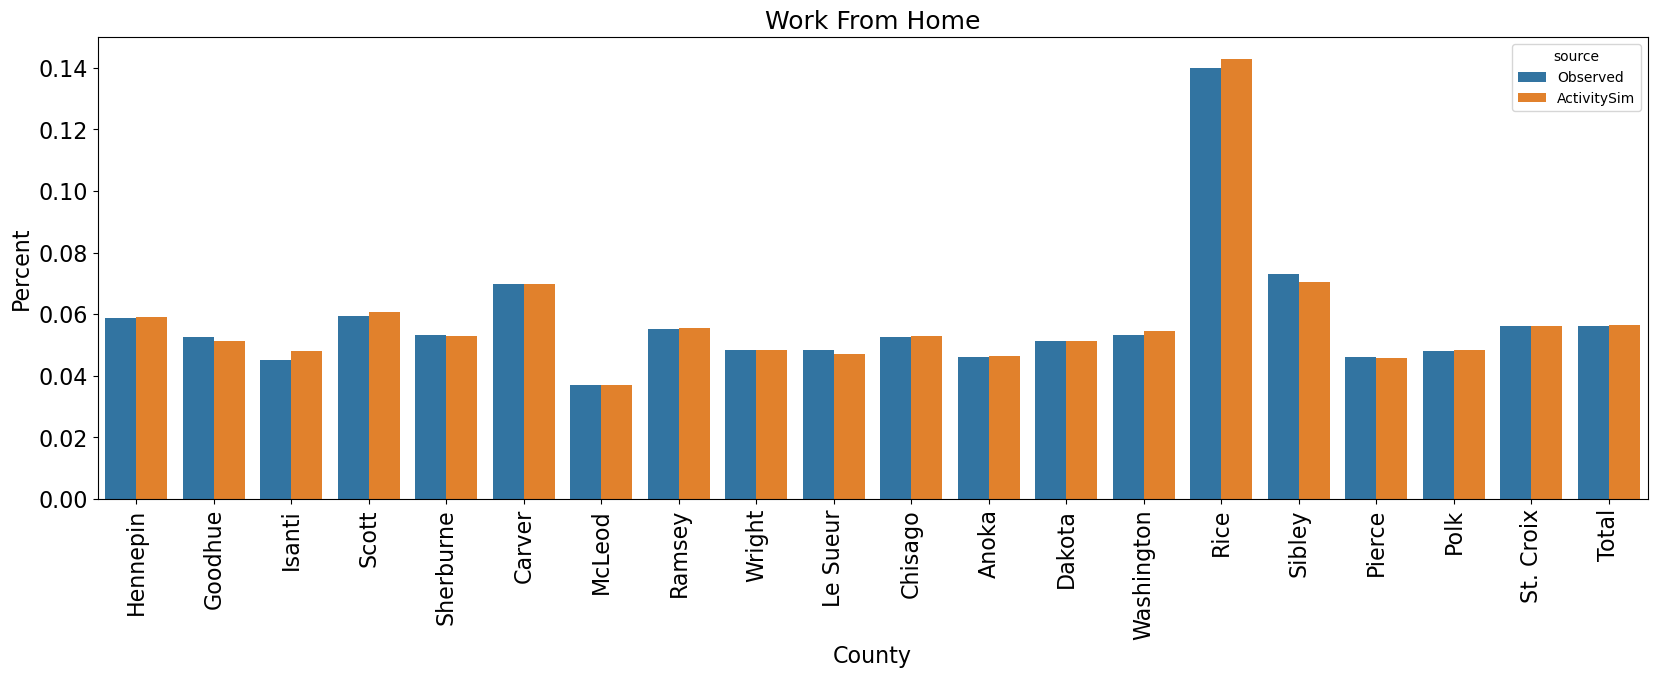

In [88]:
source_dict = {'ObsWFHPct': 'Observed', 'ModWFHPct': 'ActivitySim'}

plot_data = pd.melt(wfhCompare[['COUNTY', 'ObsWFHPct', 'ModWFHPct']], value_name = 'percent', value_vars = ['ObsWFHPct', 'ModWFHPct'], id_vars = 'COUNTY')
plot_data['source'] = plot_data['variable'].map(source_dict)
fig = plt.figure(figsize=(20, 6))
plot_idx = 111
plt.subplot(plot_idx)
sns.barplot(data = plot_data, x = 'COUNTY', y = 'percent', hue = 'source')
plt.title(f"Work From Home", fontsize=18)
plt.xticks(fontsize=16, rotation = 90)
plt.yticks(fontsize=16)
plt.ylabel('Percent', fontsize=16)
plt.xlabel('County', fontsize=16)

In [89]:
#pd.melt(wfhCompare[wfhCompare['COUNTY'] == 'Total'][['COUNTY', 'ObsWFHPct', 'ModWFHPct']], value_name = 'percent', value_vars = ['ObsWFHPct', 'ModWFHPct'], id_vars = 'COUNTY')

wfh_total = wfhCompare[wfhCompare['COUNTY'] == 'Total'][['COUNTY', 'ObsWFHPct', 'ModWFHPct']]

wfh_total['coefAdj'] = np.log(wfh_total['ObsWFHPct'] / wfh_total['ModWFHPct'])
wfh_total['coefName'] = 'coef_work_from_home_constant'

coefUpdate_total = wfh_total[['coefName', 'coefAdj']].merge(asim_config, left_on = 'coefName', right_on = 'coefficient_name')
coefUpdate_total['new_coef'] = coefUpdate_total['value'].astype(float) + coefUpdate_total['coefAdj'] * DAMPING_FACTOR

coefUpdate_total[['coefName', 'new_coef', 'constrain']].to_csv(sys.stdout, index = False)

coefName,new_coef,constrain
coef_work_from_home_constant,-0.9115337409246855,T


In [90]:
# Compute constant updates. This will dump the constants to the screen formatted for copy-paste to coefficient file. YOU MUST DO THIS MANUALLY!

countyCoefMap = {
    'Anoka': 'coef_Anoka',
    'Carver': 'coef_Carver',
    'Chisago': 'coef_Chisago',
    'Dakota': 'coef_Dakota',
    'Goodhue': 'coef_Goodhue',
    'Hennepin': 'coef_Hennepin',
    'Isanti': 'coef_Isanti',
    'Le Sueur': 'coef_LeSueur',
    'McLeod': 'coef_McLeod',
    'Pierce': 'coef_Pierce',
    'Polk': 'coef_Polk',
    'Ramsey': 'coef_Ramsey',
    'Rice': 'coef_Rice',
    'Scott': 'coef_Scott',
    'Sherburne': 'coef_Sherburne',
    'Sibley': 'coef_Sibley',
    'St. Croix': 'coef_StCroix',
    'Washington': 'coef_Washington',
    'Wright': 'coef_Wright',
}

#countyCoefMap = {'Total': 'coef_work_from_home_constant'}

wfhCompare['coefAdj'] = np.log(wfhCompare['ObsWFHPct'] / wfhCompare['ModWFHPct'])
wfhCompare['coefName'] = wfhCompare['COUNTY'].map(countyCoefMap)

coefUpdate = wfhCompare[['coefName', 'coefAdj']].merge(asim_config, left_on = 'coefName', right_on = 'coefficient_name')
coefUpdate['new_coef'] = coefUpdate['value'].astype(float) + coefUpdate['coefAdj'] * DAMPING_FACTOR

excel_file_writer = pd.ExcelWriter(excel_file, mode = 'a', engine="openpyxl", if_sheet_exists = 'replace')
coefUpdate.to_excel(excel_file_writer, f"Coef Upd {time.strftime('%Y%m%d_%H-%M')}", startrow=1)
excel_file_writer.close()

coefUpdate[['coefName', 'new_coef', 'constrain']].to_csv(sys.stdout, index = False)


coefName,new_coef,constrain
coef_Hennepin,0.7473258651075075,F
coef_Goodhue,-0.09648502612222783,F
coef_Isanti,-0.04677377494537695,F
coef_Scott,0.6627877061032994,F
coef_Sherburne,0.2070103349866441,F
coef_Carver,0.6150237603701082,F
coef_McLeod,-0.21168629718133383,F
coef_Ramsey,0.698250315922559,F
coef_Wright,0.19979641217029004,F
coef_LeSueur,-0.15400843073772685,F
coef_Chisago,0.08986169186595536,F
coef_Anoka,0.368384586277186,F
coef_Dakota,0.5247967787424739,F
coef_Washington,0.4682447964130333,F
coef_Rice,1.2601082861738793,F
coef_Sibley,0.246956499613355,F
coef_Pierce,0.03195300385781201,F
coef_Polk,-0.1699503981251423,F
coef_StCroix,0.34859366335360165,F


In [91]:
#launch_activitysim(asim_run_cmd)